I recently designed a simple strategy around intraday forex markets. The following notebook will serve as an insight into the optimization of the bot, which is meant to take profitability to the next level.

Before diving into the mathematics of the optimization process, it's important to mention this going forward: This model is pretty risky, for a variety of reasons: 

Firstly, bots like these are all at risk of "Black Swan" events, where sudden flash crashes in the market send bots in haywire, and portfolios can be wiped out, even for the largest quantitative trading firms. 

Furthermore, Forex markets are heavily leveraged due to the high stability of global currencies, and a couple deviations from expected theory could land you in debt.

Of course, trading firms have specialized strategies to reduce the volatility of the trading strategies they have, such as setting position sizes with mathematical functions like the Kelly Criterion, and using options to hedge against adverse outcomes, but there's no way to completely protect your trades from unfortunate circumstances.
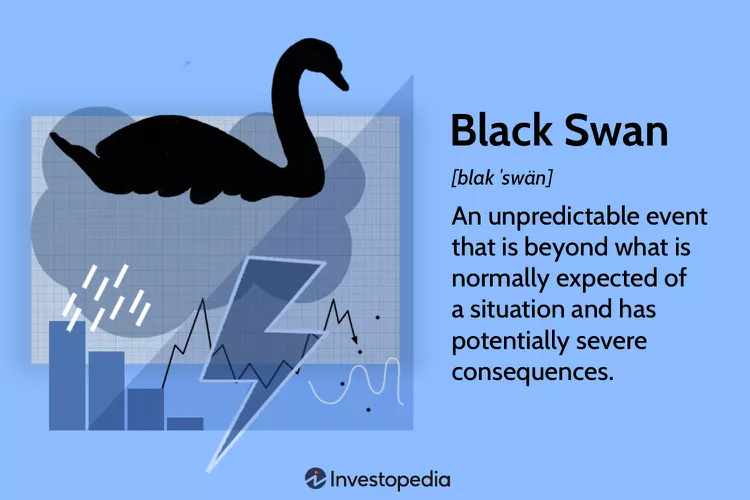
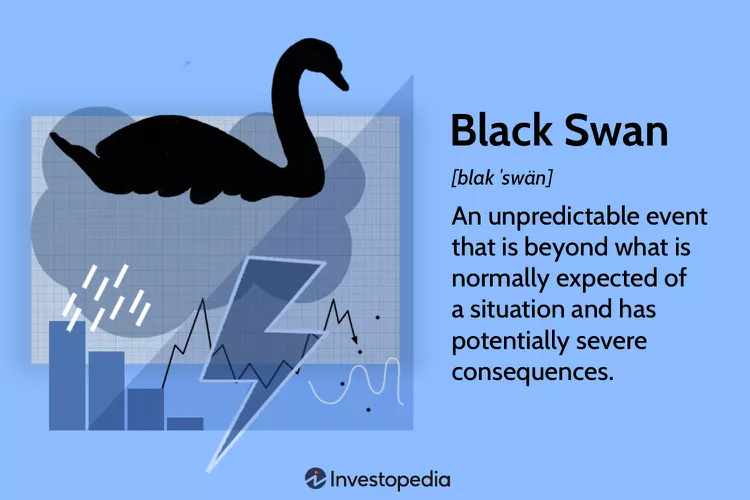

To begin, this bot primarily operates around Forex markets (currency pair trading). Using momentum trading, the bot aims to identify points where market sentiment shifts in the pair from a high, and causes the pair value to decrease as a result (or vice versa).

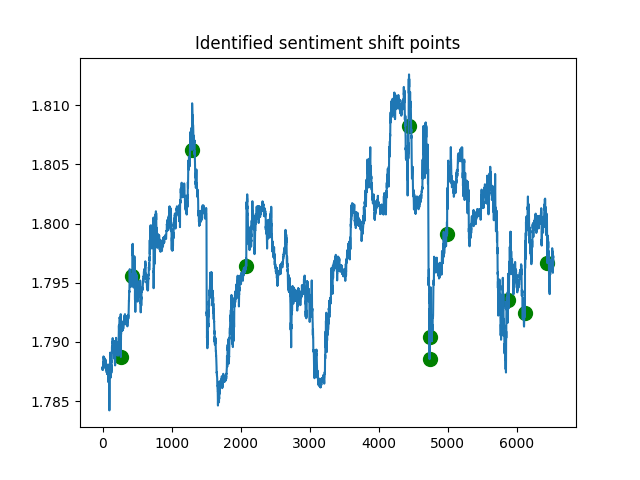

The strategy for identifying shift points (blue circles) will have to remain a trade secret. It has a roughly 48-61% chance to find a shift point that moves as expected depending on which currency pair it is applied to (tested on 5 minute granular data from 2019-2021 of various mid-high liquidity currency pairs).
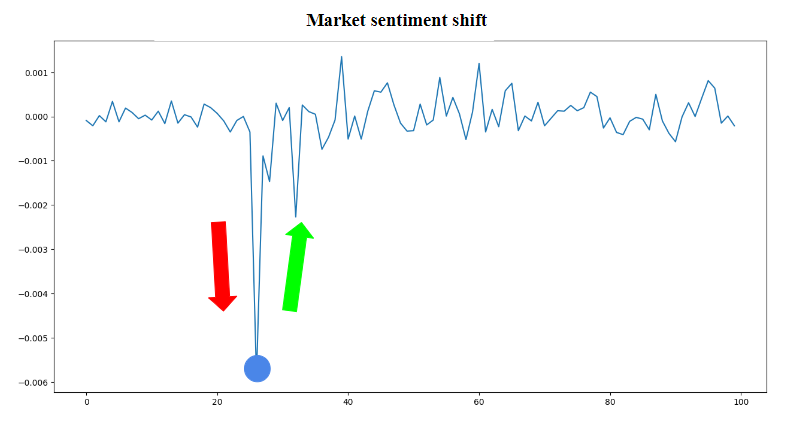
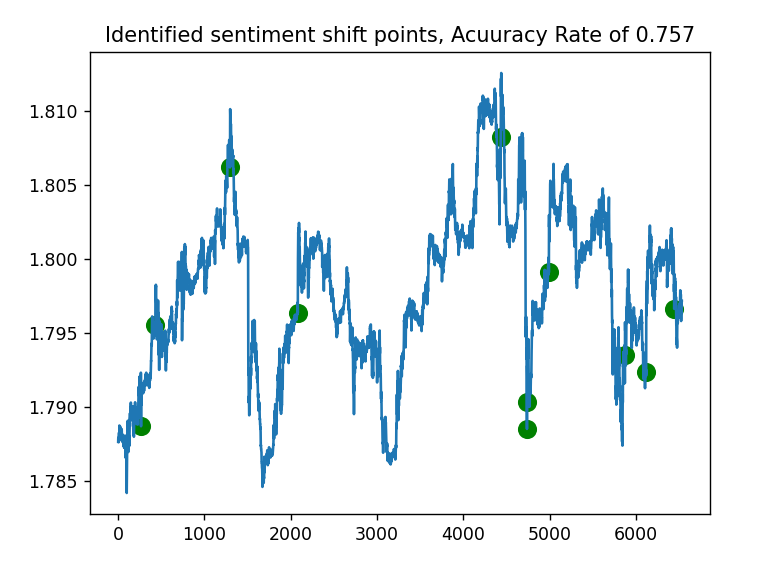
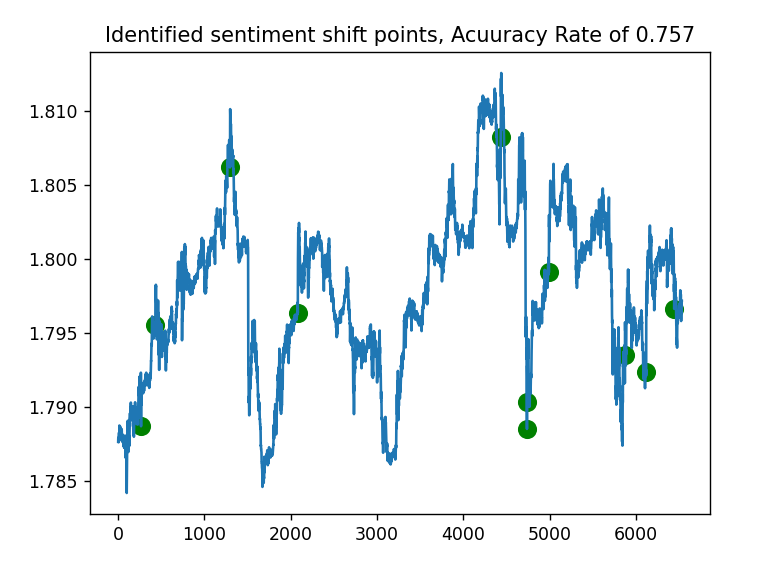
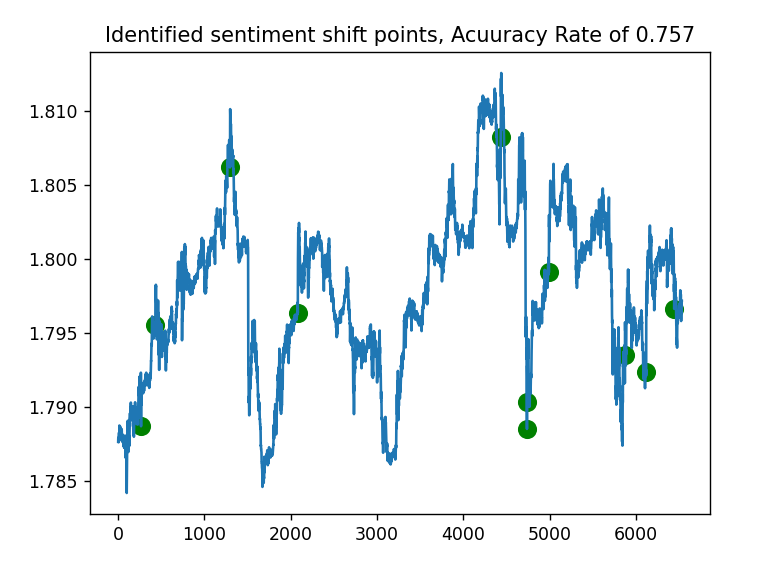
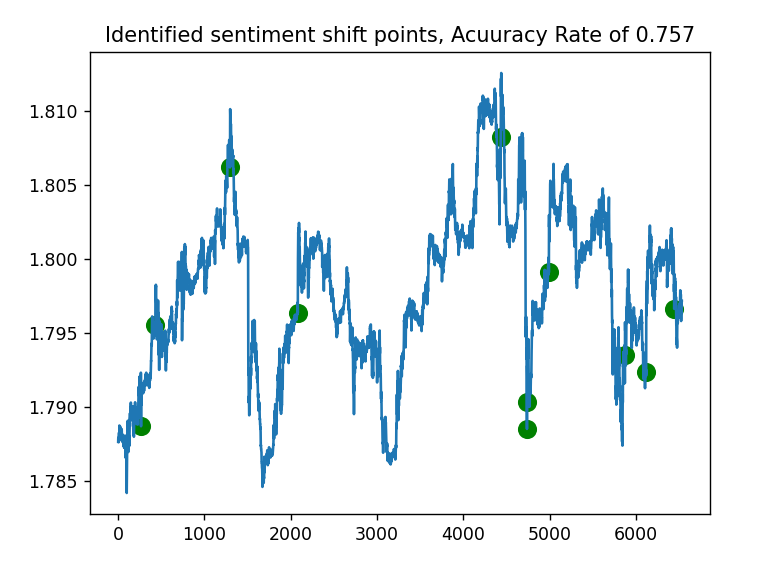

In terms of things available for optimization, the 2 most important things are:
1.  Timing when to close a position (close when certain conditions are reached)
2.  Minimizing spread costs

For the logic behind timing position closing, I've made the following 2 approaches:

In [ ]:
# Code window
def fit_parabola(data):
    """
    Fits a parabola (quadratic function) to the input data and returns the
    simplified parabolic approximation.

    Parameters:
    - data (np.ndarray or list): The input 1D array of data to fit a parabola.

    Returns:
    - parabola_values (np.ndarray): The fitted parabola values.
    - coefficients (tuple): The (a, b, c) coefficients of the quadratic equation.

    Raises:
    - ValueError: If the input data is not a 1D array or is empty.
    """
    data = np.asarray(data)

    if data.ndim != 1 or len(data) == 0:
        raise ValueError("Input must be a non-empty 1D array.")

    # Generate the x values corresponding to the data points
    x = np.arange(len(data))

    # Fit a quadratic polynomial (degree 2) to the data
    coefficients = np.polyfit(x, data, 2)

    # Use the coefficients to generate the parabolic values
    a, b, c = coefficients
    parabola_values = a * x ** 2 + b * x + c

    return parabola_values, coefficients

In [ ]:
#Code Window
def Impatient_algo(data, original_price, threshold):
    """
    This bot is designed to be a greedier, more impatient version of conventional algorithms, where the second
    the trade is profitable, the bot will sell immediately instead of waiting. 
    If the trade goes below a set amount of the original price, the bot will also close the position
    """
    for i in data:
        if i > original_price:
            return i
        if i < original_price * threshold:
            return i
    return data[-1]

The Impatient algorithm just immediately closes the position as soon as the trade is profitable or if the trade loses a certain amount of value, where although future potential gains are lost, the algorithm also closes off the likelihood of unexpected variables going against the expected trend.

Meanwhile, the parabola function just fits a parabola to the forex price data, and the rest of the algorithm is supposed to close the position once past the fitted parabola's 'vertex'. This modelling technique helps ensure that future gains (as long as they fit with a typical parabola curve) are not lost, but opens up the position to more risk than the greedy algorithm would.

Which closing strategy is better really depends on the strategy that the user is considering, but for this one, where trades are opened by identifying shift points that only last a few hours, the Impatient algorithm is better for the level of volatility inherently present in this strategy. 

For the logic behind minimizing spread, I've made the following approach based on trading when spread is below a set threshold, with the example of the GBP-CAD currency pair:

In [ ]:
# Code Window
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
from oandapyV20 import API
from oandapyV20.endpoints import instruments

inst = 'GBP_CAD'
time_move = 2000


def get_bid_ask_prices(api, instrument=inst, interval="M5"):
    """
    Fetches the bid and ask prices for the EUR/USD currency pair for the current day.
    """
    end_time = datetime.utcnow() - timedelta(minutes=time_move)  # Subtract 1 minute to avoid future timestamp issues
    start_time = datetime(end_time.year, end_time.month, end_time.day)  # Start from midnight today (UTC)

    params = {
        "from": start_time.strftime("%Y-%m-%dT%H:%M:%SZ"),
        "to": end_time.strftime("%Y-%m-%dT%H:%M:%SZ"),
        "granularity": interval,  # M5 is for 5-minute intervals
        "price": "BA"  # Request Bid and Ask prices (B = Bid, A = Ask)
    }

    r = instruments.InstrumentsCandles(instrument=instrument, params=params)
    response = api.request(r)

    bid_prices = []
    ask_prices = []
    times = []

    # Extract bid and ask prices from the candle data
    for candle in response['candles']:
        bid_prices.append(float(candle['bid']['c']))  # Closing bid price
        ask_prices.append(float(candle['ask']['c']))  # Closing ask price

    return np.array(bid_prices), np.array(ask_prices)


def plot_bid_ask_spread(bid_prices, ask_prices):
    """
    Plots the bid-ask spread for EUR/USD over time.
    """
    spread = ask_prices - bid_prices
    threshold = np.average(spread) * 1.2
    thres = [threshold for i in range(len(spread))]
    # Plot the spread over time
    plt.figure(figsize=(10, 6))
    plt.plot(spread, label='Bid-Ask Spread')
    plt.plot(thres, label='Spread Threshold')
    plt.xlabel('Time')
    plt.ylabel('Spread (Ask - Bid)')
    plt.title(f'{inst} Bid-Ask Spread for the Day')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.legend()
    plt.show()


# Initialize API
api = API(access_token="xxx") # Censored for account privacy
accountID = "xxx"

# Fetch the bid and ask prices
bid_prices, ask_prices = get_bid_ask_prices(api)

# Plot the bid-ask spread
plot_bid_ask_spread(bid_prices, ask_prices)


Explanation

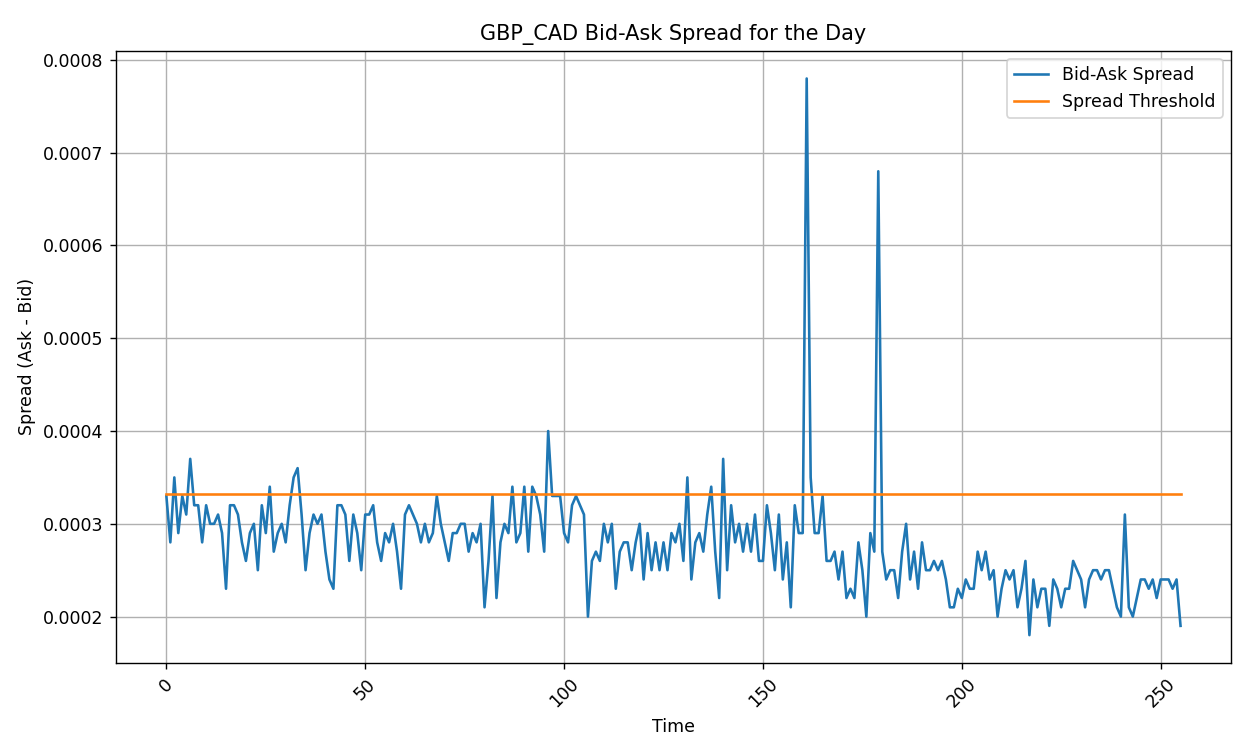
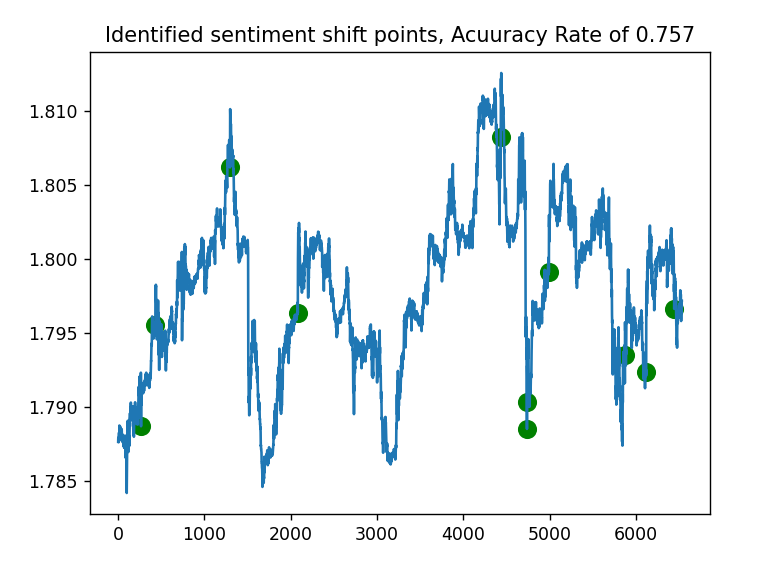

The bid-ask spread is a cost to every trade that brokers usually put on the trader. Especially for fast-paced investment strategies that profit off of small fluctuations in price, the bid-ask spread can easily reduce, or even eliminate, any potential trade profit if not carefully handled. Even with a simple threshold found by calculating the average daily spread, this step protects trades from closing at times where the spread-ask bid is at its highest. 

Even though the optimizations shown above were simple in comparison to what modern hedge funds and quantitative firms employ in their strategies, it's a good reminder that even when strategies work in a vaccuum, their preliminary success can be gradually lost due to variables like the bid-ask spread, and it's important for every trader to have a plan to handle them.